# Advanced Lane Finding
## P4 Self Driving Car Nanodegree

### Importing libraries

In [37]:
import cv2
import numpy as np
import os
import glob
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from tkinter import *
from PIL import Image,ImageTk
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
patterns_path = 'camera_cal'
test_images_path = 'test_images'
patterns_fn = glob.glob(os.path.join(os.getcwd(),patterns_path, 'calibration*.jpg'))
test_images_fn = glob.glob(os.path.join(os.getcwd(),test_images_path, '*.jpg'))

# Camera calibration

In [3]:
nx = 9
ny = 6
obj_points = []
img_points = []
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
for i in tqdm(range(len(patterns_fn))):
    fn = patterns_fn[i]
    img = cv2.imread(fn)
    #plt.imshow(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #plt.imshow(gray, cmap = 'gray')

    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        img_points.append(corners)
        obj_points.append(objp)
        # Draw and display the corners
        #cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        #plt.imshow(img)      

100%|██████████████████████████████████████████| 20/20 [00:10<00:00,  1.91it/s]


Obtain calibration and distortion matrices and save it

In [4]:
try:
    calibration_params = pickle.load(open('calibration_parameters.p', 'rb'))
    print('parameters loaded successfully')
except:
    ret, mtx, dist, _, _  = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1],None,None)
    calibration_params = dict([('mtx', mtx), ('dist', dist)])
    pickle.dump(calibration_params, open('calibration_parameters.p', 'wb'))
    print('parameters saved successfully')


parameters loaded successfully


In [5]:
def undistort(image, mtx = calibration_params['mtx'], dist = calibration_params['dist']):
    return cv2.undistort(image, calibration_params['mtx'], calibration_params['dist'], None, calibration_params['mtx'])

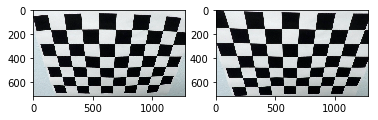

In [6]:
test_image = cv2.imread(os.path.join(os.getcwd(), patterns_path, 'calibration2.jpg'))
plt.subplot(121)
plt.imshow(test_image)
undist = undistort(test_image)
plt.subplot(122)
plt.imshow(undist)
plt.show()

In [228]:
class FramePopUp():
    def __init__(self, input_img):
        self.root = Tk()
        self.width = input_img.shape[1]
        self.height = input_img.shape[0]
        self.frame = Frame(self.root, bd=2, relief=SUNKEN)
        self.frame.grid_rowconfigure(0, weight=1)
        self.frame.grid_columnconfigure(0, weight=1)
        self.canvas = Canvas(self.frame, bd=0, width = self.width, height = self.height)
        self.canvas.grid(row=0, column=0, sticky=N+S+E+W)
        self.frame.pack(fill=BOTH,expand=1)
        self.img = ImageTk.PhotoImage(Image.fromarray(input_img))
        self.canvas.create_image(0,0,image=self.img,anchor="nw")
        self.canvas.bind("<Button 1>",self.printcoords)
        self.src_points = []
        self.click_count = 0
        mainloop()
        
    def printcoords(self,event):
        self.click_count += 1
        if self.click_count>4:
            self.root.destroy()
            return
        if self.click_count%2 == 1:
            self.canvas.create_line(0, event.y, self.width, event.y)
            self.src_points.append([event.x/self.width , event.y/self.height])
        else:
            self.src_points.append([event.x/self.width, self.src_points[-1][1]])
        self.canvas.create_oval(self.src_points[-1][0]*self.width-2,
                                self.src_points[-1][1]*self.height-2,
                                self.src_points[-1][0]*self.width+2,
                                self.src_points[-1][1]*self.height+2, fill = 'green')
        
    def get_values(self):
        return self.src_points

        
img = undistort(cv2.imread(os.path.join(os.getcwd(), test_images_path, 'straight_lines2.jpg')))
framePopUp = FramePopUp(img)

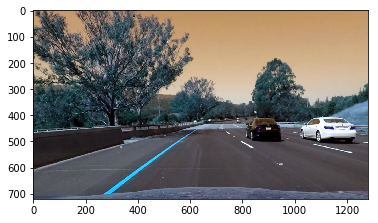

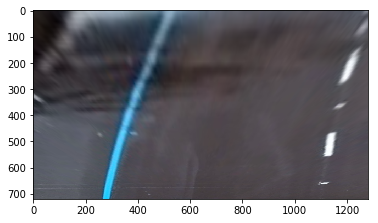

In [229]:
def get_perspective_matrix(input_img, src_points,dst_points):
    h, w = input_img.shape[0], input_img.shape[1]
    src = np.float32([[w,h],
                    [w,h],
                    [w,h],
                    [w,h]])*src_points
    dst = np.float32([[w,h],
                    [w,h],
                    [w,h],
                    [w,h]])*dst_points
    return cv2.getPerspectiveTransform(src,dst), cv2.getPerspectiveTransform(dst,src)
    
def change_to_bird_eye(input_img, M):
    h, w = input_img.shape[0], input_img.shape[1]
    return cv2.warpPerspective(input_img, M, (w, h))
dst_points = np.float32([[0.2,0],[0.8,0],[0.2,1],[0.8,1]])
src_points = np.float32(framePopUp.get_values())
img = undistort(cv2.imread(os.path.join(os.getcwd(), test_images_path, 'test6.jpg')))
M, Minv = get_perspective_matrix(img, src_points,dst_points)
plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(change_to_bird_eye(img, M))

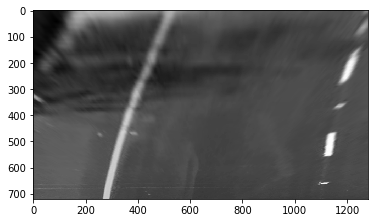

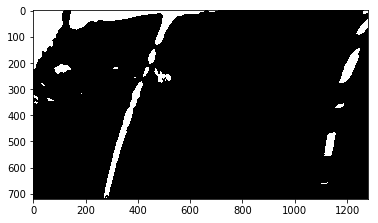

In [230]:
img = undistort(cv2.imread(os.path.join(os.getcwd(), test_images_path, 'test6.jpg')))
a = change_to_bird_eye(img,M)
b = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
c = np.zeros_like(b)
d = np.zeros_like(b)
weights = np.linspace(0.3,0.14,b.shape[0])
for i, row in enumerate(b): 
    c[i,:] = np.convolve(b[i,:],[-weights[i],-1,-weights[i]], 'same')
    d[i,:] = np.convolve(b[i,:],[-weights[i],-.1,-weights[i]], 'same')
lane_lines_discriminated = np.bitwise_or(c>200,d<180)
plt.imshow(b,cmap = 'gray')
plt.figure()
plt.imshow(lane_lines_discriminated,cmap = 'gray')
plt.show()

100%|██████████████████████████████████████████| 15/15 [00:12<00:00,  2.13it/s]


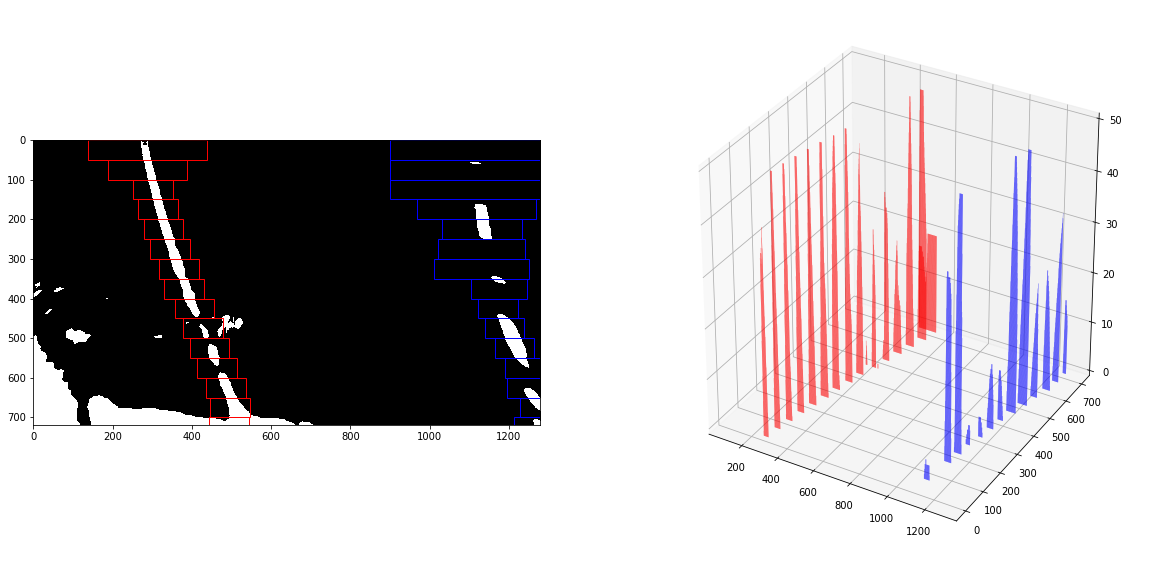

In [231]:

fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')
batch_size = 50
left_windows_width = 200
right_windows_width = 200
left_mean = 300
right_mean = 1100
binary_image = lane_lines_discriminated[::-1]
left_image = np.zeros_like(binary_image)
right_image = np.zeros_like(binary_image)
ax1.imshow(binary_image, cmap = 'gray')

for i in tqdm(range(0, len(binary_image),batch_size)):
    x = np.linspace(0,binary_image.shape[1],binary_image.shape[1])
    x_left = x[left_mean-left_windows_width:left_mean+left_windows_width]
    y_left_test = binary_image[left_mean-left_windows_width:left_mean+left_windows_width]
    y_left = np.sum(binary_image[i:i+batch_size,left_mean-left_windows_width:left_mean+left_windows_width], axis = 0)
    if np.max(y_left)>5:
        left_mean = int(x_left[np.argmax(y_left)])
        left_windows_width = max(50, left_windows_width-50)
    else:
        left_windows_width = min(200, left_windows_width+10)
    left_image[i:i+batch_size,left_mean-left_windows_width:left_mean+left_windows_width] = binary_image[i:i+batch_size,left_mean-left_windows_width:left_mean+left_windows_width]    
    
    x_right = x[right_mean-right_windows_width:right_mean+right_windows_width]
    y_right = np.sum(binary_image[i:i+batch_size,right_mean-right_windows_width:right_mean+right_windows_width], axis = 0)
    if np.max(y_right)>5:
        right_mean = int(x_right[np.argmax(y_right)])
        right_windows_width = max(50, right_windows_width-50)
    else:
        right_windows_width = min(200, right_windows_width+10)
    right_image[i:i+batch_size,right_mean-right_windows_width:right_mean+right_windows_width] = binary_image[i:i+batch_size,right_mean-right_windows_width:right_mean+right_windows_width]    
    ax1.add_patch(patches.Rectangle((left_mean-left_windows_width,i), 2*left_windows_width,batch_size, fill = False,edgecolor="red"))
    ax1.add_patch(patches.Rectangle((right_mean-right_windows_width,i), 2*right_windows_width,batch_size,fill = False,edgecolor="blue"))
    ax2.bar(x_left,y_left,i,zdir='y',color = 'r')
    ax2.bar(x_right,y_right,i,zdir='y',color = 'b')

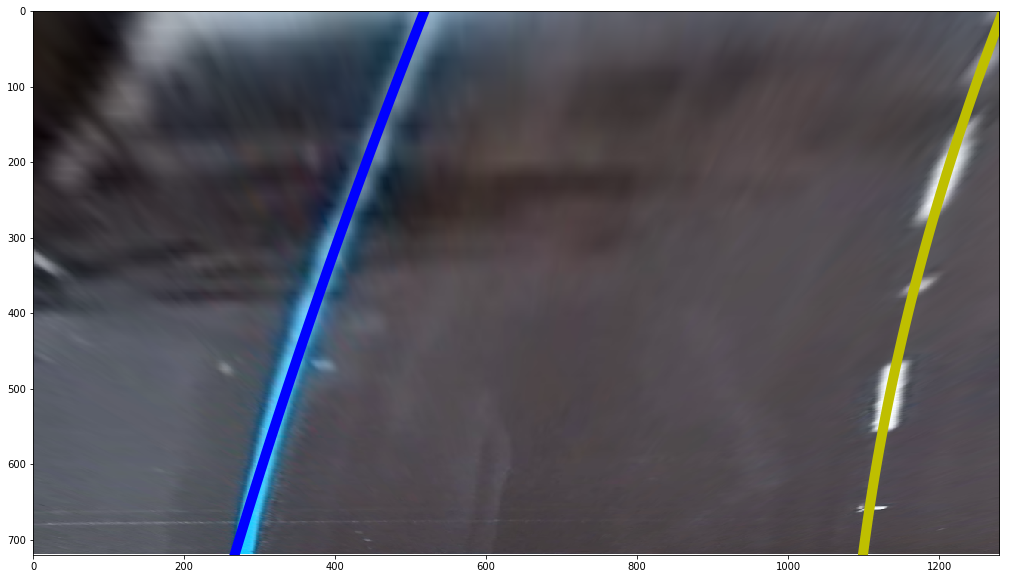

In [232]:
[y_left_points,x_left_points] = np.nonzero(left_image[::-1])
[y_right_points,x_right_points] = np.nonzero(right_image[::-1])
left_fit_coef = np.polyfit(y_left_points,x_left_points,2)
right_fit_coef = np.polyfit(y_right_points,x_right_points,2)
left_poly = np.poly1d(left_fit_coef)
right_poly = np.poly1d(right_fit_coef)
y_points = np.linspace(0,binary_image.shape[0], 100)
plt.figure(figsize = (20,10))
axes = plt.gca()
axes.set_xlim([0,1280])
axes.set_ylim([720,0])
plt.imshow(a)
plt.plot(left_poly(y_points),y_points,  linewidth = 10, color = 'b' )
plt.plot(right_poly(y_points),y_points, linewidth = 10, color = 'y')
plt.show()

In [233]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(y_left_points*ym_per_pix, x_left_points*xm_per_pix, 2)
right_fit_cr = np.polyfit(y_right_points*ym_per_pix, x_right_points*xm_per_pix, 2)
y_eval = binary_image.shape[0]
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m
offset = (img.shape[1]/2-(right_poly(img.shape[0])+left_poly(img.shape[0]))/2)*xm_per_pix
print(offset,img.shape[0])

2481.02263456 m 926.007349002 m
-0.227713330965 720


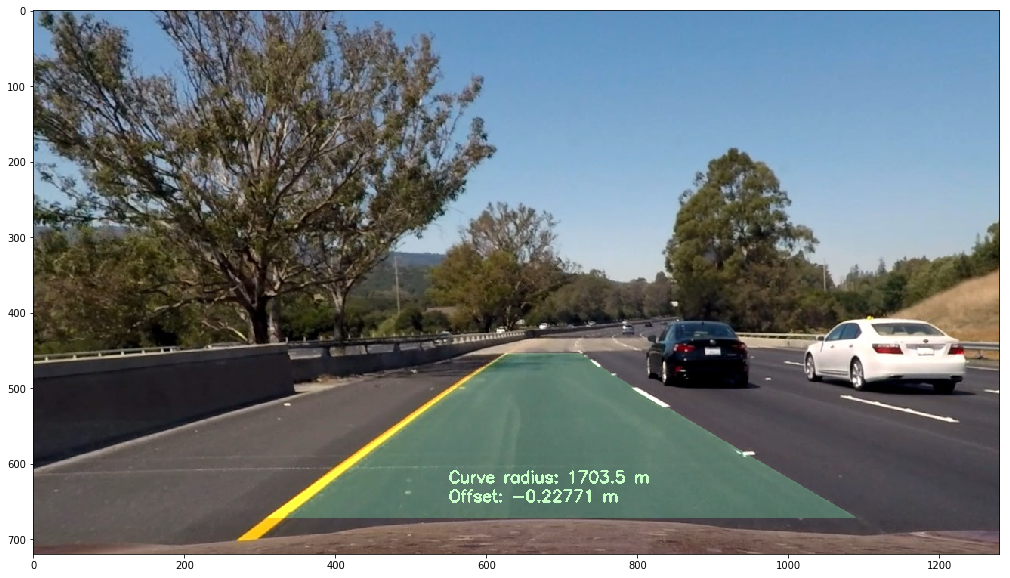

In [234]:
output_image = warp_zero = np.zeros_like(img).astype(np.uint8)
pts_left = np.array([np.transpose(np.vstack([left_poly(y_points), y_points]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_poly(y_points), y_points])))])
pts = np.hstack((pts_left, pts_right))
cv2.fillPoly(output_image, np.int_([pts]), (55,174, 105))
output_image = cv2.warpPerspective(output_image, Minv, (output_image.shape[1], output_image.shape[0]))
result = cv2.addWeighted(cv2.cvtColor(img,cv2.COLOR_BGR2RGB), 1, output_image, 0.3, 0)
text1 = 'Curve radius: ' + '{:.5}'.format(np.mean([left_curverad,right_curverad])) + ' m'
text2 = 'Offset: ' + '{:.5}'.format(offset) + ' m'
cv2.putText(result,text1, (550,625), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (200,255,200),2)
cv2.putText(result,text2, (550,650), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (200,255,200),2)
plt.figure(figsize = (20,10))
plt.imshow(result)

In [ ]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize = sobel_kernel)
    abs_x = np.absolute(sobelx)
    abs_y = np.absolute(sobely)
    orientation = np.arctan2(abs_y, abs_x)
    binary_output = np.zeros_like(orientation)
    binary_output[(orientation >= thresh[0]) & (orientation <= thresh[1])] = 1
    return binary_output

def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, orient == 'x', orient == 'y'))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] =  1
    return binary_output

In [ ]:
class SliderPopUp():
    def __init__(self, input_img):
        self.i = 0
        self.root = Tk()
        self.w1 = Scale(self.root, from_=0, to=255, orient=HORIZONTAL, length = 960, label = 'HL', command=self.update_img)
        self.w1.pack()
        self.w2 = Scale(self.root, from_=0, to=255, orient=HORIZONTAL, length = 960, label = 'HH', command=self.update_img)
        self.w2.pack()
        self.w3 = Scale(self.root, from_=0, to=255, orient=HORIZONTAL, length = 960, label = 'SL', command=self.update_img)
        self.w3.pack()
        self.w4 = Scale(self.root, from_=0, to=255, orient=HORIZONTAL, length = 960, label = 'SH', command=self.update_img)
        self.w4.pack()
        self.w5 = Scale(self.root, from_=0, to=255, orient=HORIZONTAL, length = 960, label = 'VL', command=self.update_img)
        self.w5.pack()
        self.w6 = Scale(self.root, from_=0, to=255, orient=HORIZONTAL, length = 960, label = 'VH', command=self.update_img)
        self.w6.pack()
        Button(self.root, text='save', command=self.save_values).pack()
        self.img = input_img
        self.panel1 = Label(self.root)
        self.panel1.pack(side ='left')
        self.panel2 = Label(self.root)
        self.panel2.pack(side ='left')
        self.panel3 = Label(self.root)
        self.panel3.pack()
        mainloop()

    def update_img(self, new_value):
        channel_1 = cv2.inRange(self.img[:,:,0], self.w1.get(), self.w2.get())
        channel_2 = cv2.inRange(self.img[:,:,1], self.w3.get(), self.w4.get())
        channel_3 = cv2.inRange(self.img[:,:,2], self.w5.get(), self.w6.get())
        image1 = ImageTk.PhotoImage(Image.fromarray(channel_1))
        image2 = ImageTk.PhotoImage(Image.fromarray(channel_2))
        image3 = ImageTk.PhotoImage(Image.fromarray(channel_3))
        self.panel1.configure(image = image1)
        self.panel1.image = image1
        self.panel2.configure(image = image2)
        self.panel2.image = image2
        self.panel3.configure(image = image3)
        self.panel3.image = image3
    def save_values(self):
        self.values = [self.w1.get(), self.w2.get(), self.w3.get(),self.w4.get(), self.w5.get(), self.w6.get()]
        self.root.destroy()
    def get_values(self):
        return self.values



In [ ]:
img = cv2.imread(os.path.join(os.getcwd(), test_images_path, 'test2.jpg'))
img = cv2.resize(img, None, fx=.25, fy= .25, interpolation =  cv2.INTER_AREA)

img.shape
a = SliderPopUp(cv2.cvtColor(img,cv2.COLOR_BGR2HLS))
a.get_values()
values = []
for i, fn in enumerate(test_images_fn):
    img = cv2.imread(fn)
    img = cv2.resize(img, None, fx=.25, fy= .25, interpolation =  cv2.INTER_AREA)
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)

    HLS = cv2.cvtColor(undist_img, cv2.COLOR_BGR2HLS)
    a = SliderPopUp(cv2.cvtColor(undist_img,cv2.COLOR_BGR2HLS))
    a.get_values()
    values.append(a.get_values())
    del(a)
for i, fn in enumerate(test_images_fn):
    img = cv2.imread(fn)
    img = cv2.resize(img, None, fx=.25, fy= .25, interpolation =  cv2.INTER_AREA)
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    rgb = cv2.cvtColor(undist_img, cv2.COLOR_BGR2RGB)
    HLS = cv2.cvtColor(undist_img, cv2.COLOR_BGR2HLS)
    H = HLS[:,:,0]
    L = HLS[:,:,1]
    S = HLS[:,:,2]

    plt.figure()
    plt.imshow(rgb)
    dir_thresh = dir_threshold(rgb,thresh= (0.9,1.0))
    plt.figure()
    plt.imshow(dir_thresh,cmap = 'gray')

    """
    plt.figure()
    plt.imshow(H,cmap = 'gray')
    H_thresh = cv2.adaptiveThreshold(H,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,101,2)
    plt.figure()
    plt.imshow(H_thresh,cmap = 'gray')

    plt.figure()
    plt.imshow(L,cmap = 'gray')
    L_thresh = cv2.adaptiveThreshold(L,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,101,2)
    plt.figure()
    plt.imshow(L_thresh,cmap = 'gray')

    plt.figure()
    plt.imshow(S,cmap = 'gray')
    S_thresh = cv2.adaptiveThreshold(S,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,501,2)
    plt.figure()
    plt.imshow(S_thresh,cmap = 'gray')"""

